In [13]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.1  # Minimum distance constraint
    
    for _ in range(num_points):
        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(0, 1)
                y = np.random.uniform(0, 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(0.1, 1)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 1000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.617323, y = 0.195579, mass = 0.5200, force = [-6.397744e-01, 3.071772e+00]]
  Particle 2: [x = 0.399087, y = 0.551340, mass = 0.8636, force = [3.114403e+00, -1.925662e+00]]
  Particle 3: [x = 0.977415, y = 0.640267, mass = 0.7086, force = [-2.474629e+00, -1.146110e+00]]

Data point 2:
  Particle 1: [x = 0.469989, y = 0.784120, mass = 0.9134, force = [3.690623e+00, -8.548577e-01]]
  Particle 2: [x = 0.909523, y = 0.760797, mass = 0.6821, force = [-3.148464e+00, -8.196367e-01]]
  Particle 3: [x = 0.951806, y = 0.095930, mass = 0.6455, force = [-5.421595e-01, 1.674494e+00]]

Data point 3:
  Particle 1: [x = 0.183023, y = 0.541612, mass = 0.7067, force = [5.450148e-01, -8.736164e+00]]
  Particle 2: [x = 0.437170, y = 0.371397, mass = 0.4123, force = [-4.132702e+00, 1.699179e+00]]
  Particle 3: [x = 0.131427, y = 0.364704, mass = 0.3506, force = [3.587687e+00, 7.036985e+00]]



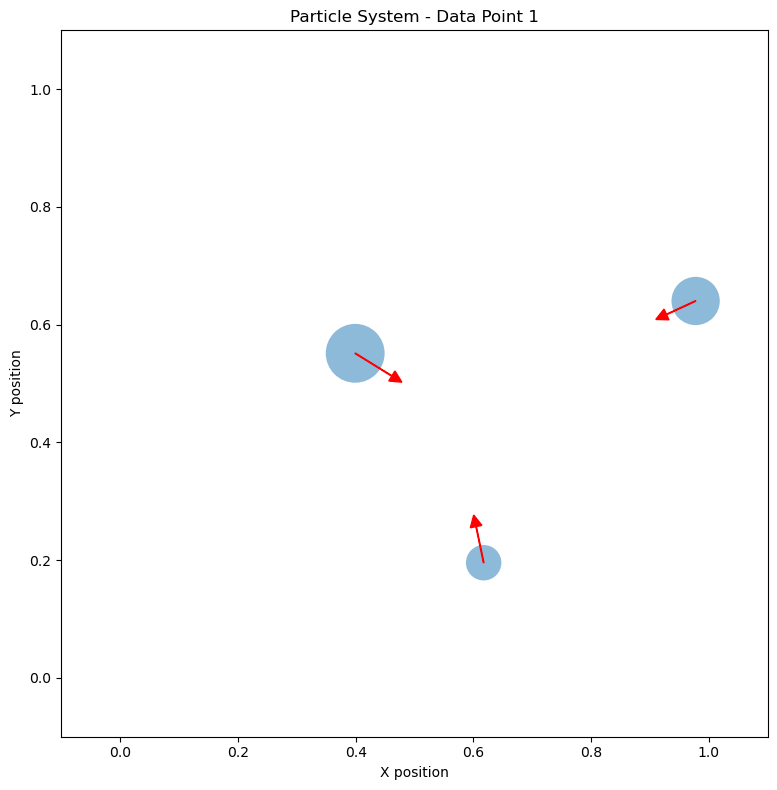

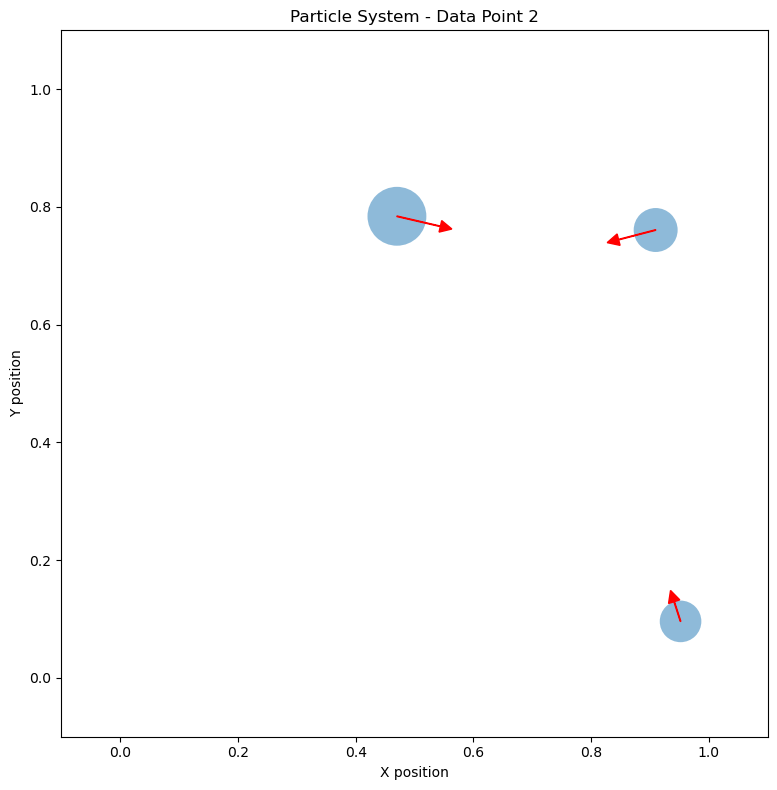

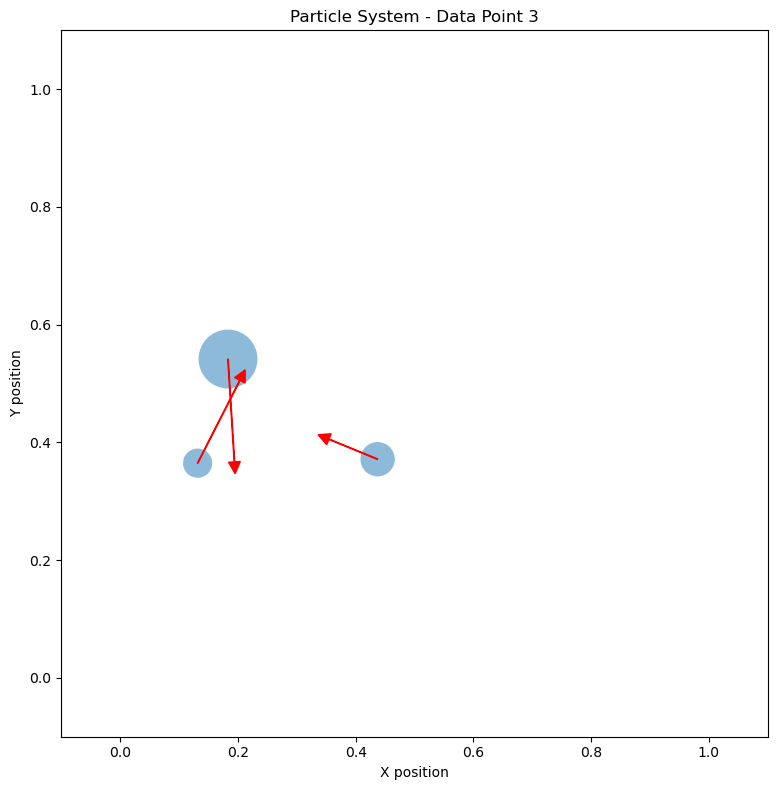

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 128),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        out = self.mlp(tmp)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features.
        out = torch.cat([x, edge_attr], dim=1)
        return edge_attr

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.2737, 0.8210, 0.9281],
        [0.5123, 0.1334, 0.9522],
        [0.2604, 0.4035, 0.2671]])
Input:
tensor([[0.2737, 0.8210, 0.9281],
        [0.5123, 0.1334, 0.9522],
        [0.2604, 0.4035, 0.2671]])

Output (forces):
tensor([[-0.1084, -0.1171],
        [-0.1456, -0.1114],
        [-0.0990, -0.1172]], grad_fn=<ScatterAddBackward0>)


In [16]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.6173233262104022, 0.19557876639132765, 0.5199529469155366, [-0.6397744383981298, 3.0717723769654266]], [0.3990870701007081, 0.5513399725332021, 0.8635978006405212, [3.1144030562602647, -1.925662227192351]], [0.9774149710182486, 0.6402673769296703, 0.7085587691085022, [-2.474628617862135, -1.1461101497730757]]]
[[0.46998926558104714, 0.7841203341512475, 0.9134488060906136, [3.6906234867579784, -0.8548576740657876]], [0.9095226293665303, 0.7607968811078691, 0.6820707777354613, [-3.1484639934049716, -0.8196367332189298]], [0.9518062150763157, 0.0959297752909879, 0.6455444539017043, [-0.5421594933530071, 1.6744944072847174]]]


tensor([[0.6173, 0.1956, 0.5200],
        [0.3991, 0.5513, 0.8636],
        [0.9774, 0.6403, 0.7086]])
tensor([[0.4700, 0.7841, 0.9134],
        [0.9095, 0.7608, 0.6821],
        [0.9518, 0.0959, 0.6455]])


tensor([[-0.6398,  3.0718],
        [ 3.1144, -1.9257],
        [-2.4746, -1.1461]])
tensor([[ 3.6906, -0.8549],
        [-3.1485, -0.8196],
        [-0.542

Using device: cuda
Epoch [1/200], Loss: 32.8394, Learning Rate: 0.0190000000
Epoch [2/200], Loss: 29.1313, Learning Rate: 0.0180500000
Epoch [3/200], Loss: 25.4949, Learning Rate: 0.0171475000


Epoch [4/200], Loss: 19.4967, Learning Rate: 0.0162901250
Epoch [5/200], Loss: 14.0402, Learning Rate: 0.0154756187
Epoch [6/200], Loss: 12.5124, Learning Rate: 0.0147018378
Epoch [7/200], Loss: 17.4094, Learning Rate: 0.0139667459
Epoch [8/200], Loss: 9.0625, Learning Rate: 0.0132684086
Epoch [9/200], Loss: 7.5123, Learning Rate: 0.0126049882
Epoch [10/200], Loss: 4.9348, Learning Rate: 0.0119747388
Epoch [11/200], Loss: 3.1650, Learning Rate: 0.0113760018
Epoch [12/200], Loss: 2.1678, Learning Rate: 0.0108072018
Epoch [13/200], Loss: 2.0405, Learning Rate: 0.0102668417
Epoch [14/200], Loss: 1.3402, Learning Rate: 0.0097534996
Epoch [15/200], Loss: 1.3815, Learning Rate: 0.0092658246
Epoch [16/200], Loss: 1.7560, Learning Rate: 0.0088025334
Epoch [17/200], Loss: 2.6215, Learning Rate: 0.0083624067
Epoch [18/200], Loss: 1.3718, Learning Rate: 0.0079442864
Epoch [19/200], Loss: 1.0589, Learning Rate: 0.0075470721
Epoch [20/200], Loss: 0.7205, Learning Rate: 0.0071697184
Epoch [21/200], 

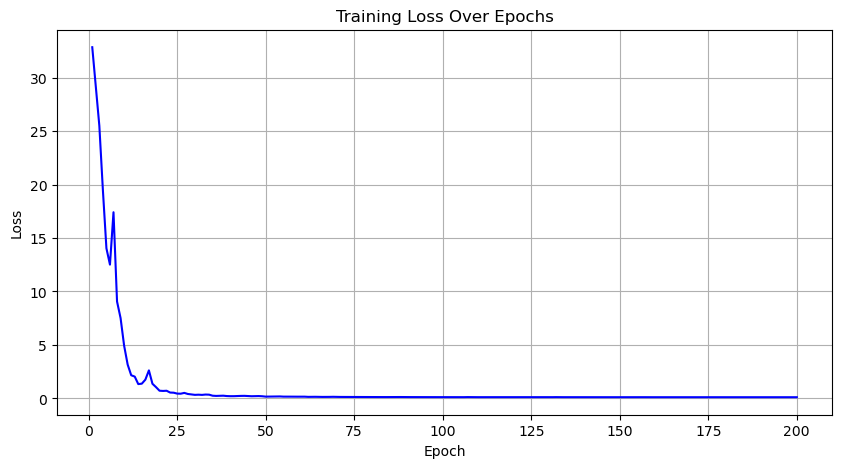

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.95)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 200  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [18]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 0.4744


In [19]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

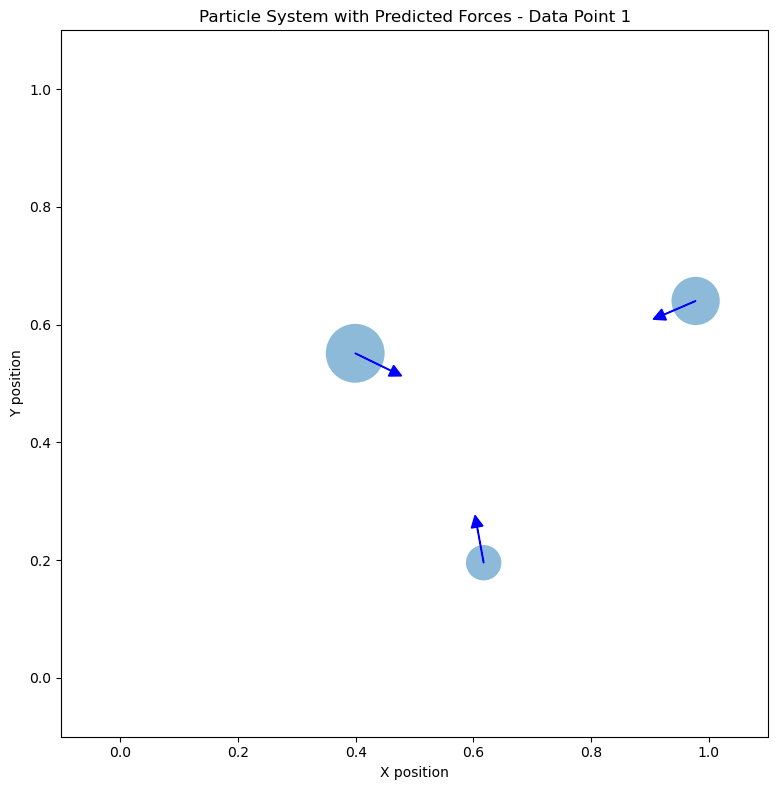

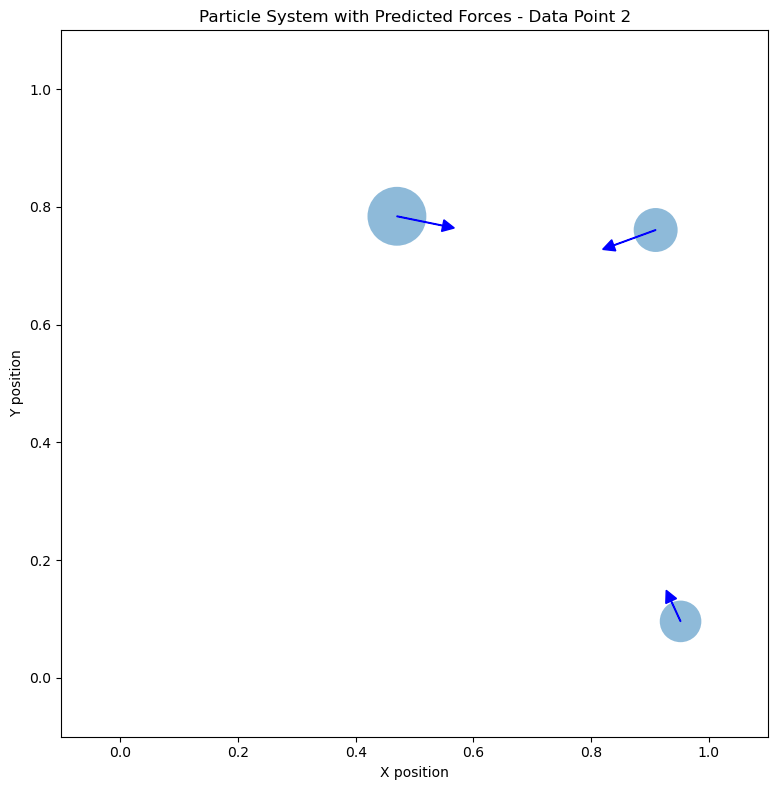

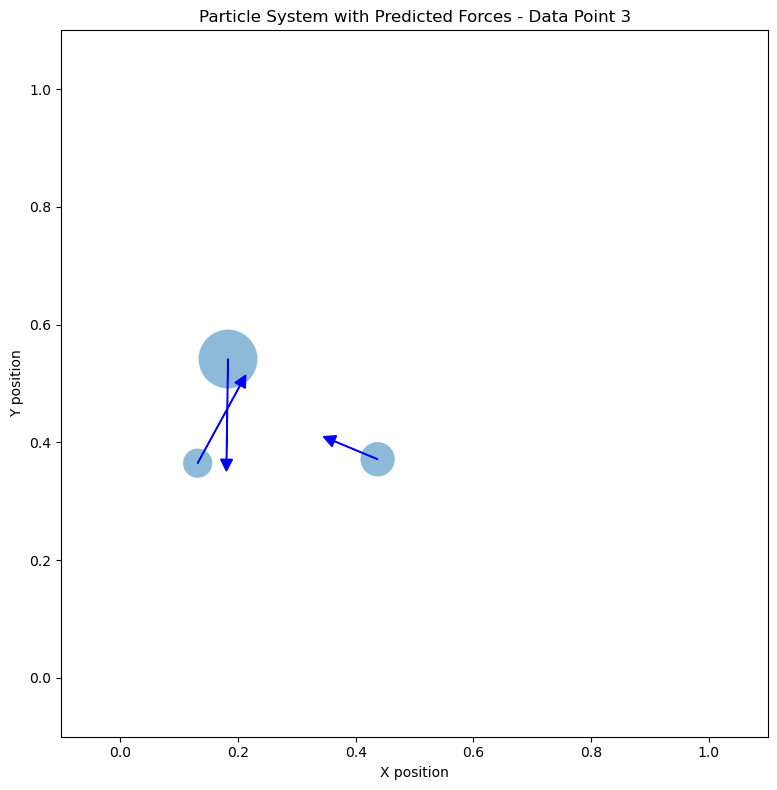

In [20]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = (mass / max_mass) / 20  # Scale radius relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [21]:
print(particle_dataset[0])

[[0.6173233262104022, 0.19557876639132765, 0.5199529469155366, [-0.6397744383981298, 3.0717723769654266]], [0.3990870701007081, 0.5513399725332021, 0.8635978006405212, [3.1144030562602647, -1.925662227192351]], [0.9774149710182486, 0.6402673769296703, 0.7085587691085022, [-2.474628617862135, -1.1461101497730757]]]


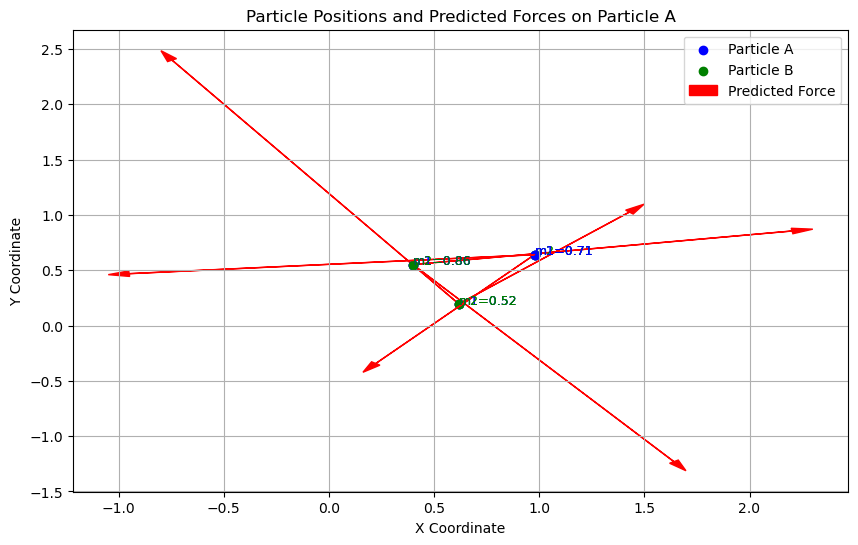

In [22]:
# Organize the data for PySR

input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

# Sample input data and predicted forces from the provided examples
input_data_sample = input_data[:6]  # Extracting the first 5 samples
predicted_forces_sample = predicted_forces[:6]  # Extracting the first 5 predicted forces

plt.figure(figsize=(10, 6))

# Loop over the examples to plot each one
for i in range(len(input_data_sample)):
    # Extract particle data
    x1, y1, mass1, x2, y2, mass2 = input_data_sample[i]
    Fx, Fy = predicted_forces_sample[i]

    # Plot particles positions
    plt.scatter(x1, y1, color='blue', label='Particle A' if i == 0 else "")
    plt.scatter(x2, y2, color='green', label='Particle B' if i == 0 else "")

    # Draw force vector on Particle A
    plt.arrow(x1, y1, Fx, Fy, head_width=0.05, head_length=0.1, fc='red', ec='red', label='Predicted Force' if i == 0 else "")

    # Annotate masses
    plt.text(x1, y1, f"m1={mass1:.2f}", fontsize=9, color='blue')
    plt.text(x2, y2, f"m2={mass2:.2f}", fontsize=9, color='green')

# Set plot properties
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Particle Positions and Predicted Forces on Particle A')
plt.grid(True)
plt.legend()
plt.show()


In [24]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

model.fit(input_data, predicted_forces)

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 6.110e+04
Head worker occupation: 12.1%
Progress: 141 / 1200 total iterations (11.750%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.618e+01  1.594e+01  y₀ = x₃
3           1.565e+01  1.685e-02  y₀ = x₃ - x₀
5           1.540e+01  7.919e-03  y₀ = (x₃ - x₀) * 2.2025
6           1.540e+01  5.364e-07  y₀ = (x₃ - x₀) * sqrt(4.8171)
7           1.525e+01  1.003e-02  y₀ = (x₃ - x₀) / (1.1496 - x₅)
9           1.511e+01  4.520e-03  y₀ = ((x₃ - x₀) * (x₅ + x₂)) / 0.4539
11          1.502e+01  2.943e-03  y₀ = (x₃ - x₀) / (1.1496 - ((x₅ * x₂) * 1.1496))
12          1.502e+01  2.194e-04  y₀ = (x₃ - x₀) / (1.1496 - ((sqrt(x₅) * x₂) * 1.1496))
13          1.500e+01  1.636e-03  y₀ = (x₃ - x₀) / ((1.1496 - ((x₅ * x₂) * 1.1496)) / 1.0836)
17          1.497e+01  3.490e-04  y₀ = (x₃ - x₀) / (((1.1496 - (x₀ * (0.77654 *

PySRRegressor.equations_ = [
[
	   pick     score                                           equation  \
	0        0.000000                                                 x3   
	1  >>>>  0.016852                                            x3 - x0   
	2        0.007920                              2.1948373 * (x3 - x0)   
	3        0.006213                       ((x3 - x0) * 3.9817178) * x2   
	4        0.003320               ((x3 - x0) * (x5 + x2)) / 0.45390397   
	5        0.002943  (x3 - x0) / (1.1496334 - ((1.1496334 * x2) * x5))   
	6        0.000219  (x3 - x0) / (1.1496334 - ((sqrt(x5) * x2) * 1....   
	7        0.013422  (x3 - x0) / ((1.1496334 - ((1.1496334 * x2) * ...   
	8        0.002480  (x3 - x0) / ((1.1496334 - (x5 * (1.1496334 * x...   
	
	        loss  complexity  
	0  16.184826           1  
	1  15.648408           3  
	2  15.402500           5  
	3  15.212292           7  
	4  15.111621           9  
	5  15.022922          11  
	6  15.019628          12  
	7  14.819388          13  
	8  14.746073          15  
], [
	    pick     score                                           equation  \
	0         0.000000                                  sqrt(2.209749e-5)   
	1   >>>>  0.034708                                            x4 - x1   
	2         0.007158                              (x4 - x1) * 2.1538467   
	3         0.006270                       (x4 - x1) * (x5 * 3.8998108)   
	4         0.007917               (x5 * ((x4 - x1) * x2)) / 0.15667418   
	5         0.000239  (x5 * ((x4 - x1) * (x2 * 1.1945511))) / 0.1566...   
	6         0.000375  (x5 * ((x4 - x1) * (x2 * sqrt(1.2000995)))) / ...   
	7         0.000178  (x5 * ((x4 - x1) * ((x2 + -0.044345737) * 1.19...   
	8         0.003247  ((x4 - x1) * (x5 / 0.2653562)) * (x2 + sqrt(x1...   
	9         0.011864  x2 * (((x4 - x1) * (x5 / 0.09785147)) * ((x4 *...   
	10        0.000845  (((sqrt(x4) - sqrt(x1)) * (x5 / 0.09785147)) *...   
	11        0.000055  (((sqrt(x4) - sqrt(x1)) * ((x5 / 0.09785147) -...   
	
	         loss  complexity  
	0   16.612100           2  
	1   16.045414           3  
	2   15.817359           5  
	3   15.620263           7  
	4   15.374865           9  
	5   15.367516          11  
	6   15.361760          12  
	7   15.359030          13  
	8   15.309242          14  
	9   15.128685          15  
	10  15.090364          18  
	11  15.088698          20  
]]